In [103]:
import pandas as pd
import os
import numpy as np
from IPython.display import display,display_html
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")
os.chdir(r'D:\CaseStudy\demand-forecasting-kernels-only')

In [21]:
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [144]:
#The training dataset contains 5 years of daily
#sales volumes of 50 items in 10 stores 
#(500 time series in total, from 2013 to 2017).

train = pd.read_csv('train.csv',parse_dates=['date'])
test = pd.read_csv('test.csv',parse_dates=['date'])
train.sales = train.sales.astype(np.float)
#test.sales = test.sales.astype(np.float)
display_side_by_side(train.head(),test.head())

#The goal is to predict sales volumes of all items 
#in all stores in the first quarter of 2018. 
#The evaluation metric is SMAPE:average 2|yi−yi^|/(yi+yi^)⋅100%.

,date,store,item,sales
0,2013-01-01,1,1,13.0
1,2013-01-02,1,1,11.0
2,2013-01-03,1,1,14.0
3,2013-01-04,1,1,13.0
4,2013-01-05,1,1,10.0
,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1


In [145]:
#Data could be non-stationary
#Sales in stores could be correlated
#Data could have trend and seasonality
#Distribution may change based on time
display(pd.concat([train.isnull().sum().rename('Training NaNs'),
                   test.isnull().sum().rename('Test NaNs')], axis=1))

,Training NaNs,Test NaNs
date,0.0,0.0
id,NaN,0.0
item,0.0,0.0
sales,0.0,NaN
store,0.0,0.0


In [146]:
#Creating date attributes
#train.reset_index()
train['Week']=train['date'].dt.week
train['Month']=train['date'].dt.month
train['Quarter']=train['date'].dt.quarter
train['Year']=train['date'].dt.year
train['Day']=train['date'].dt.day_name()
train['DayofWeek']=train['date'].dt.weekday
train['days']=train['date'].dt.day
train.head()

,date,store,item,sales,Week,Month,Quarter,Year,Day,DayofWeek,days
0,2013-01-01,1,1,13.0,1,1,1,2013,Tuesday,1,1
1,2013-01-02,1,1,11.0,1,1,1,2013,Wednesday,2,2
2,2013-01-03,1,1,14.0,1,1,1,2013,Thursday,3,3
3,2013-01-04,1,1,13.0,1,1,1,2013,Friday,4,4
4,2013-01-05,1,1,10.0,1,1,1,2013,Saturday,5,5


In [168]:
train.groupby('date').mean()['sales'].head()

date
2013-01-01    27.392
2013-01-02    27.356
2013-01-03    28.976
2013-01-04    31.354
2013-01-05    32.474
Name: sales, dtype: float64

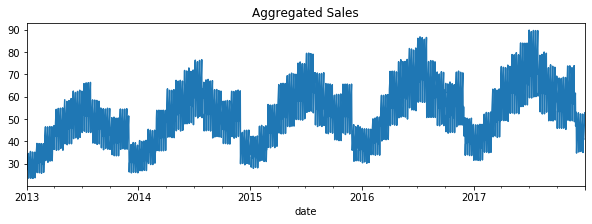

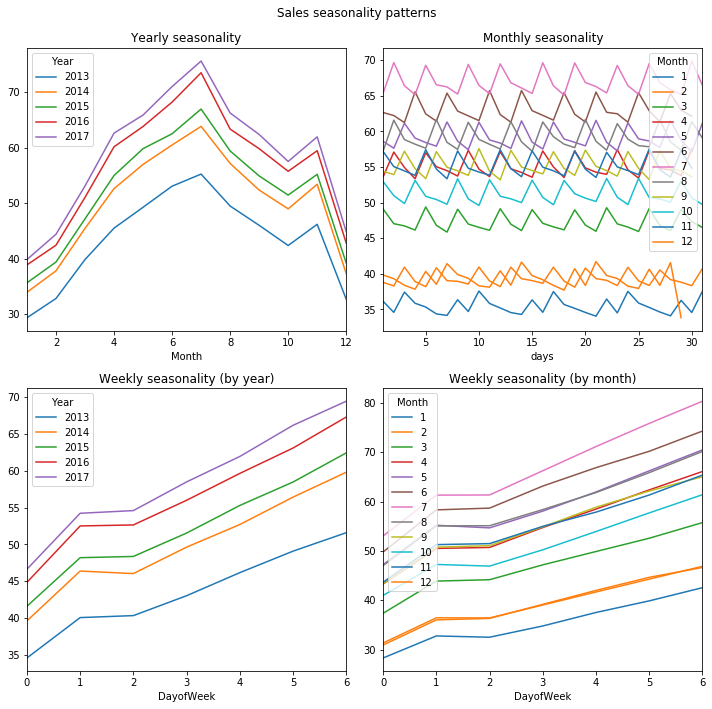

In [120]:
#Analysing seasonality pattern
train.groupby('date').mean()['sales'].plot(figsize=(10,3),title='Aggregated Sales');
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
_ = pd.pivot_table(train, values='sales', columns='Year', index='Month').plot(title="Yearly seasonality", ax=ax[0,0])
_ = pd.pivot_table(train, values='sales', columns='Month', index='days').plot(title="Monthly seasonality", ax=ax[0,1])
_ = pd.pivot_table(train, values='sales', columns='Year', index='DayofWeek').plot(title="Weekly seasonality (by year)", ax=ax[1,0])
_ = pd.pivot_table(train, values='sales', columns='Month', index='DayofWeek').plot(title="Weekly seasonality (by month)", ax=ax[1,1])
fig.suptitle('Sales seasonality patterns')
fig.tight_layout(rect=[0, 0, 1, 0.96])

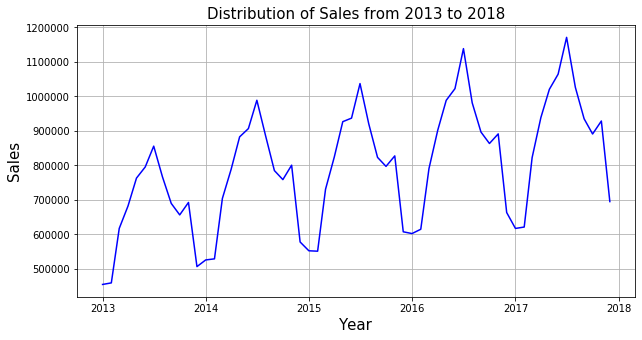

In [192]:
#STL Decomposition of Monthly aggregated sales
#Transform the data into monthly average
train['Newdate']=train['date'].dt.year.astype('str')+'-'+train['date'].dt.month.astype('str')+'-'+'01'
train['Newdate'] = pd.to_datetime(train['Newdate'])
sales=train.groupby('Newdate')['sales'].sum().reset_index()
#result = seasonal_decompose(sales['sales'], model='additive')
#result.plot();
#sales.head()
#result.seasonality


plt.figure(figsize=(10,5))
plt.title('Distribution of Sales from 2013 to 2018',fontsize=15)
plt.ylabel('Sales',fontsize=15)
plt.xlabel('Year',fontsize=15)
color = 'blue'
plt.grid()
plt.axis('on')
#sales.plot(x='date',y='sales',color = color);
plt.plot(sales['Newdate'],sales['sales'],color=color);

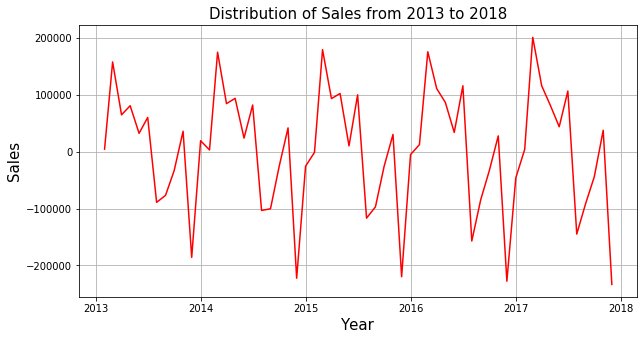

In [193]:
#Since the data is not stationary
#using differencing method to 
#convert into stationary data
#add previous sales to the next row
sales['prev_sales'] = sales['sales'].shift(1)
sales=sales.dropna()
sales['diff']=sales['sales'] - sales['prev_sales']


plt.figure(figsize=(10,5))
plt.title('Distribution of Sales from 2013 to 2018',fontsize=15)
plt.ylabel('Sales',fontsize=15)
plt.xlabel('Year',fontsize=15)
#color = plt.cm.PuOr(np.linspace(0, 1, 25))
color='red'
plt.grid()
plt.axis('on')
#sales.plot(x='date',y='sales',color = color);
plt.plot(sales['Newdate'],sales['diff'],color=color);

In [194]:
#sales.head()
#sales =sales.set_index('Newdate')
#sales.index=pd.to_datetime(sales.index)
sales.head()

,Newdate,sales,prev_sales,diff
1,2013-02-01,459417.0,454904.0,4513.0
2,2013-03-01,617382.0,459417.0,157965.0
3,2013-04-01,682274.0,617382.0,64892.0
4,2013-05-01,763242.0,682274.0,80968.0
5,2013-06-01,795597.0,763242.0,32355.0


In [195]:
#We need to use previous monthly sales data to 
#forecast the next ones. The look-back period may 
#vary for every model. Ours will be 12 for this example
for i in range(1,13):
    field_name='lag_'+str(i)
    sales[field_name]=sales['diff'].shift(i)

In [196]:
#drop null values
sales = sales.dropna().reset_index(drop=True)
sales.head()

,Newdate,sales,prev_sales,diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
0,2014-02-01,529117.0,525987.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,2014-03-01,704301.0,529117.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,2014-04-01,788914.0,704301.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,2014-05-01,882877.0,788914.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,2014-06-01,906842.0,882877.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
